In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing and Installing Libraries

In [2]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import statsmodels.api as sm
from statsmodels.genmod.families.links import log
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import shapiro, spearmanr
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
# Load the cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/Data690 Project/Cleaned_data.csv')

## VADER Integration:

## Compound Score Calculation:

- For every Yelp review, we'll calculate the compound score by summing up the sentiment scores of individual words provided by VADER.
- This compound score offers a comprehensive perspective on sentiment, considering both the positivity/negativity and intensity of emotions.

## Method for Analysis:

- We'll employ VADER to break down the text of Yelp reviews, assigning sentiment scores to each word based on its emotional intensity.
- By combining these scores, we'll generate a compound score for each review, providing an overall sentiment analysis.

In [5]:
analyzer = SentimentIntensityAnalyzer()
# Function to get compound sentiment score
def get_compound_sentiment_score(text):
    if pd.isna(text):
        return 0  # Return a neutral score for missing reviews
    return analyzer.polarity_scores(str(text))['compound']

# Convert 'Reviews' column to string and apply function to the dataset
df['Reviews'] = df['Reviews'].astype(str)
df['compound_sentiment_score'] = df['Reviews'].apply(get_compound_sentiment_score)

## Output Interpretation:

- The resulting compound score, ranging from -1 to 1, serves as an indicator of the sentiment expressed in the Yelp review.
- **Score Interpretation:**
  - **Positive (0.05 to 1):** Indicates a positive sentiment, with higher values signifying greater positivity.
  - **Neutral (-0.05 to 0.05):** Suggests a neutral sentiment, neither positive nor negative.
  - **Negative (-1 to -0.05):** Points to a negative sentiment, with lower values indicating more negativity.
- The magnitude of the compound score gives us insight into the intensity of the sentiment, allowing for a nuanced understanding of the emotional tone in the Yelp reviews.

In [6]:
df.head()

,Reviews,Rating,Rev_len,compound_sentiment_score
0,decide eat aware going take hours beginning en...,3,513,0.8968
1,second time tried turning point location first...,2,477,-0.3535
2,place cute staff friendly nice menu good brunc...,4,216,0.9538
3,came saturday morning waiting months opening h...,3,736,0.8965
4,mediocre best decor nice like restaurant tryin...,2,953,0.9050


In [7]:
print('Review: ',df.Reviews[2])
print('Compound Score: ',df.compound_sentiment_score[2])

Review:  place cute staff friendly nice menu good brunch lunch seated right away really enjoyed avocado toast side bacon nice another brunch place nearby
Compound Score:  0.9538


In [8]:
print('Review: ',df.Reviews[1])
print('Compound Score: ',df.compound_sentiment_score[1])

Review:  second time tried turning point location first time long wait food ordering time even longer wait minutes omelette skillet hardly egg felt like eating chopped onions chopped tomatoes wife blt hard time finding tomato avocado supposed overall experience stressful mainly long wait
Compound Score:  -0.3535


## Analyzing our features and Target variable

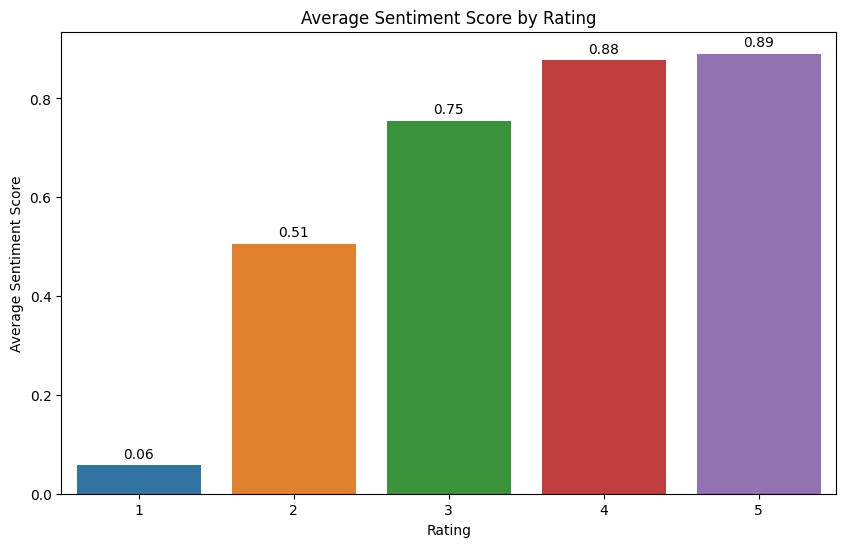

In [9]:
# Group by 'Rating' and calculate the mean sentiment score
sentiment_by_rating = df.groupby('Rating')['compound_sentiment_score'].mean()

# Plotting
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=sentiment_by_rating.index, y=sentiment_by_rating.values)
plt.title('Average Sentiment Score by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment Score')

# Add the data labels on the bars
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.2f'),
                 (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                 size=10, xytext=(0, 8),
                 textcoords='offset points')

plt.show()

There is an exponential increase in sentiment score from Ratings 1 to 3. However the difference is minute for ratings 4 and 5. This trend is increasign and can be useful for businessed to determine and predict the sentiment score they need to increase their value by in order to get better ratings.

## Hypothesis Testing

In [10]:
"""# Loading CSV file into the Data Frame"""
# Normality test for 'Rev_len' and 'compound_sentiment_score'
print("Shapiro Test for Normality")
print("Rev_len:", shapiro(df['Rev_len']))
print("Compound Sentiment Score:", shapiro(df['compound_sentiment_score']))

# Spearman correlation
corr, p_value = spearmanr(df['Rev_len'], df['compound_sentiment_score'])
print("\nSpearman Correlation")
print("Correlation Coefficient:", corr)
print("P-value:", p_value)

Shapiro Test for Normality
Rev_len: ShapiroResult(statistic=0.7516698837280273, pvalue=0.0)
Compound Sentiment Score: ShapiroResult(statistic=0.5849083662033081, pvalue=0.0)

Spearman Correlation
Correlation Coefficient: 0.47021206654954606
P-value: 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## TF-IDF Vectorization

- Since it is text data, each word is a feature, each complaint has unnecessary features, which might not be relevant for classification model.
- TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects how important a word is to a document in a collection or corpus.
- TF-IDF gives higher weights to terms that are frequent in a specific review but not common across all reviews. This helps in identifying words that are distinctive to a particular review and might carry sentiment or topic-specific information.

In [11]:
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['Reviews'])

# One-Hot Encoding for 'Rating'
encoder = OneHotEncoder(categories='auto', drop=None)
ratings_encoded = encoder.fit_transform(df[['Rating']].astype(str))

# Combine TF-IDF features with one-hot encoded 'Rating' and 'Rev_len'
combined_features = hstack([tfidf_matrix, ratings_encoded, csr_matrix(df[['Rev_len']].astype(float))])

# Define the target variable
target = df['compound_sentiment_score']


- We have combined the TF-IDF sparse matrix with our other important features i.e Ratings and the Review length to form one sparse matrix feature for training our model.

In [12]:
target.shape

(64282,)

In [13]:
combined_features.shape

(64282, 1006)

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, target, test_size=0.2, random_state=42)

# Convert the sparse matrix to a dense format and add a constant
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
X_train_sm = sm.add_constant(X_train_dense)
X_test_sm = sm.add_constant(X_test_dense)

## GLM

In [15]:
# Initialize and fit the GLM model
model = sm.GLM(y_train, X_train_sm, family=sm.families.Gaussian())
results = model.fit()

# Predict on the test set
glm_pred = results.predict(X_test_sm)

## Gradient Boost, XGBoost and Random Forest Models

In [16]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)

# XGBoost Regressor
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)
xgbr_pred = xgbr.predict(X_test)

In [17]:
#GLM
mse1 = mean_squared_error(y_test, glm_pred)
rmse1 = np.sqrt(mse1)
r2_1 = r2_score(y_test, glm_pred)
mae1 = mean_absolute_error(y_test, glm_pred)
explained_variance1 = explained_variance_score(y_test, glm_pred)

#GradientBoost
mse2 = mean_squared_error(y_test, gbr_pred)
rmse2 = np.sqrt(mse2)
r2_2 = r2_score(y_test, gbr_pred)
mae2 = mean_absolute_error(y_test, gbr_pred)
explained_variance2 = explained_variance_score(y_test, gbr_pred)

#XGBoost
mse3 = mean_squared_error(y_test, xgbr_pred)
rmse3 = np.sqrt(mse3)
r2_3 = r2_score(y_test, xgbr_pred)
mae3 = mean_absolute_error(y_test, xgbr_pred)
explained_variance3 = explained_variance_score(y_test, xgbr_pred)

data = {
    'Metric': ['Mean Squared Error', 'Root Mean Squared Error', 'R-squared', 'Mean Absolute Error', 'Explained Variance'],
    'GLM': [mse1, rmse1, r2_1, mae1, explained_variance1],
    'Gradient Boosting': [mse2, rmse2, r2_2, mae2, explained_variance2],
    'X Gradient Boosting': [mse3, rmse3, r2_3, mae3, explained_variance3]
}

comparison_table = pd.DataFrame(data)
print(comparison_table)


                    Metric       GLM  Gradient Boosting  X Gradient Boosting
0       Mean Squared Error  0.067269           0.070797             0.059425
1  Root Mean Squared Error  0.259363           0.266076             0.243772
2                R-squared  0.611791           0.591434             0.657060
3      Mean Absolute Error  0.170324           0.152701             0.134581
4       Explained Variance  0.611798           0.591434             0.657066


**Analysis:**

- **X Gradient Boosting Excellence:** X Gradient Boosting performs relatively well. It achieves the lowest Mean Squared Error and Root Mean Squared Error, good proficiency in capturing patterns within the review features.

- **GLM Precision in Absolute Values:** GLM, while exhibiting a slightly higher Mean Squared Error, excels in Mean Absolute Error. This suggests that it is effective in capturing the absolute magnitude of sentiment, showcasing precision in the context of sentiment analysis.

- **R-squared and Variance Explanation:** The R-squared values highlight the proportion of variance in sentiment scores explained by each model. X Gradient Boosting, with the highest R-squared, stands out in elucidating a significant portion of the variability in sentiment, showcasing its ability to interpret nuanced patterns within Yelp reviews.

In [18]:
sample_indices = np.random.choice(len(y_test), size=2000, replace=False) # Randomly select 2000 data points randomly
y_test_sample = y_test.iloc[sample_indices]
gbr_pred_sample = gbr_pred[sample_indices]
xgbr_pred_sample = xgbr_pred[sample_indices]
glm_pred_sample = glm_pred[sample_indices]

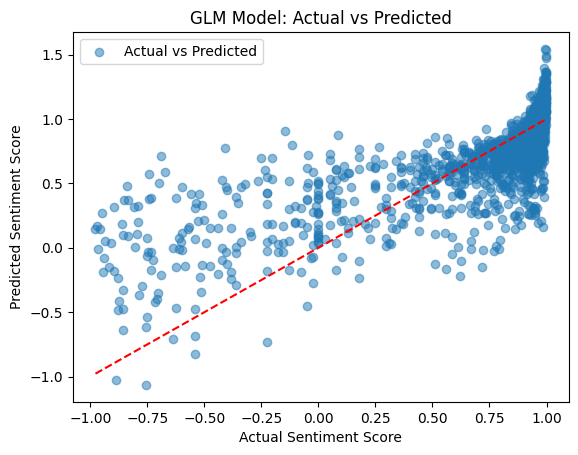

In [19]:
# Plot for GLM
plt.scatter(y_test_sample, glm_pred_sample, alpha=0.5, label='Actual vs Predicted')
plt.title('GLM Model: Actual vs Predicted')
plt.xlabel('Actual Sentiment Score')
plt.ylabel('Predicted Sentiment Score')

reg_line_sample = np.linspace(min(y_test_sample), max(y_test_sample), 100)
plt.plot(reg_line_sample, reg_line_sample, color='red', linestyle='--')

plt.legend()
plt.show()

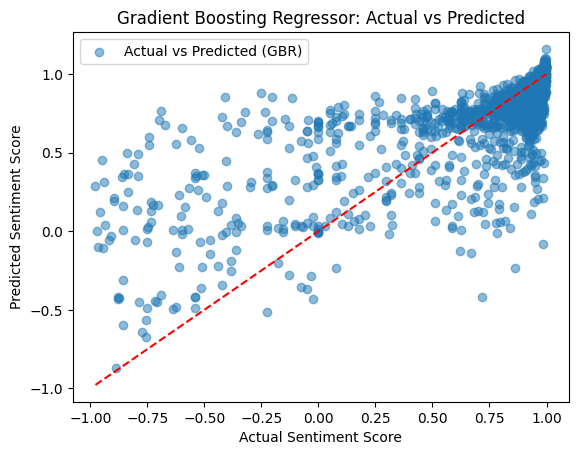

In [20]:
# Plot for Gradient Boosting Regressor
plt.scatter(y_test_sample, gbr_pred_sample, alpha=0.5, label='Actual vs Predicted (GBR)')
plt.title('Gradient Boosting Regressor: Actual vs Predicted')
plt.xlabel('Actual Sentiment Score')
plt.ylabel('Predicted Sentiment Score')

reg_line_gbr_sample = np.linspace(min(y_test_sample), max(y_test_sample), 100)
plt.plot(reg_line_gbr_sample, reg_line_gbr_sample, color='red', linestyle='--',)

plt.legend()
plt.show()

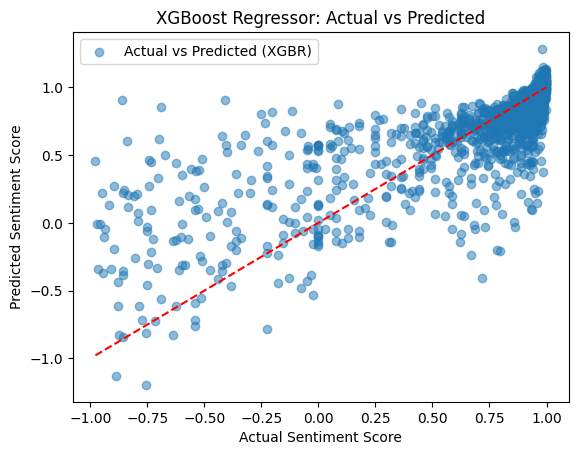

In [21]:
# Plot for XGBoost Regressor
plt.scatter(y_test_sample, xgbr_pred_sample, alpha=0.5, label='Actual vs Predicted (XGBR)')
plt.title('XGBoost Regressor: Actual vs Predicted')
plt.xlabel('Actual Sentiment Score')
plt.ylabel('Predicted Sentiment Score')

reg_line_xgbr_sample = np.linspace(min(y_test_sample), max(y_test_sample), 100)
plt.plot(reg_line_xgbr_sample, reg_line_xgbr_sample, color='red', linestyle='--')

plt.legend()
plt.show()

#### Hyper-Parameter tuning for XG-Boost Regressor

In [32]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for XGBoost Regressor
xgbr_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 4, 5]
}
# Grid search for XGBoost Regressor
xgbr_grid = GridSearchCV(xgb.XGBRegressor(), xgbr_params, cv=3, verbose=2, n_jobs=-1)
xgbr_grid.fit(X_train, y_train)

# Best parameters and scores
print("Best parameters for XGBoost Regressor:", xgbr_grid.best_params_)
print("Best score for XGBoost Regressor:", xgbr_grid.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for XGBoost Regressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best score for XGBoost Regressor: 0.6499302911614574


In [33]:
# XGBoost Regressor
xgbr_grid = xgb.XGBRegressor(learning_rate =  0.1, max_depth= 5, n_estimators= 300)
xgbr_grid.fit(X_train, y_train)
xgbr_grid_pred = xgbr_grid.predict(X_test)

In [34]:
# Evaluate the model
mse = mean_squared_error(y_test, xgbr_grid_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, xgbr_grid_pred)
r2 = r2_score(y_test, xgbr_grid_pred)
explained_variance = explained_variance_score(y_test, xgbr_grid_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)
print("Mean Absolute Error:", mae)
print("Explained Variance Score:", explained_variance)

Mean Squared Error: 0.0577523402618521
Root Mean Squared Error: 0.24031716597416028
R-squared Score: 0.6667119352136783
Mean Absolute Error: 0.13345304460270194
Explained Variance Score: 0.6667128532851356


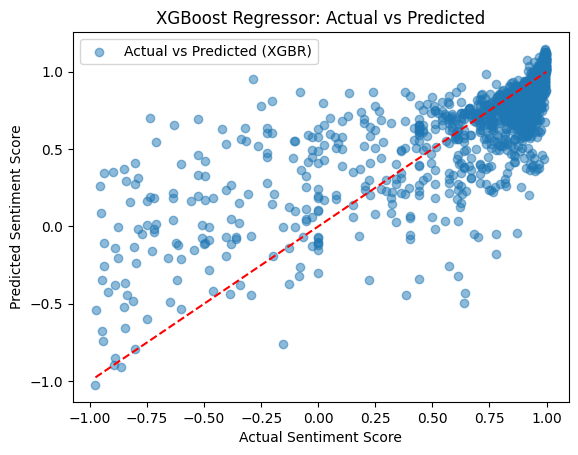

In [36]:
sample_indices = np.random.choice(len(y_test), size=2000, replace=False) # Randomly select 2000 data points randomly
y_test_sample = y_test.iloc[sample_indices]
xgbr_grid_pred_sample = xgbr_grid_pred[sample_indices]
# Plot for XGBoost Regressor
plt.scatter(y_test_sample, xgbr_grid_pred_sample, alpha=0.5, label='Actual vs Predicted (XGBR)')
plt.title('XGBoost Regressor: Actual vs Predicted')
plt.xlabel('Actual Sentiment Score')
plt.ylabel('Predicted Sentiment Score')

reg_line_xgbr_sample = np.linspace(min(y_test_sample), max(y_test_sample), 100)
plt.plot(reg_line_xgbr_sample, reg_line_xgbr_sample, color='red', linestyle='--')

plt.legend()
plt.show()